In [ ]:
#Dependecy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from celer import Lasso as CelerLasso

In [34]:
# DataSet generation
data_set = dict()

with open("stocks.txt", "r") as f:
    stocks = [line.strip() for line in f if line.strip()]

for stock in stocks:
    df = pd.read_csv(
        f"csv/{stock}_indicators.csv",
        index_col=0,       # use first column ("Date") as index
        parse_dates=[0],    # parse it as datetime
        date_format="ISO8601" #Specify date fromat
    ) 
    # ensure numeric and drop rows with NaNs in target/features
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=['Target'])
    X = df.drop(columns=["Target"])
    Y = df["Target"]

    train_mask = X.index < "2025-01-01"
    test_mask = X.index >= "2025-01-01"
    X_train, X_test = X[train_mask], X[test_mask]
    Y_train, Y_test = Y[train_mask], Y[test_mask]
    
    if len(X_train) == 0 or len(X_test) == 0:
        print(f"Skipping storing {stock}: empty train/test split")
        continue

    
    data_set[stock] = {
        "X_train": X_train,
        "X_test": X_test,
        "Y_train": Y_train,
        "Y_test": Y_test
    }

    print("="*20 + stock + "="*20)
    print(f"Traing size {len(X_train)}")
    print(f"Test size {len(X_test)}\n")


====================AAPL====================
Traing size 2514
Test size 182

====================META====================
Traing size 2514
Test size 182

====================ORCL====================
Traing size 2514
Test size 182

====================MSFT====================
Traing size 2514
Test size 182




--- sklearn Lasso (coordinate descent) for AAPL ---


Best params (sklearn): {'sklasso__alpha': 0.01, 'sklasso__max_iter': 10000} 
 MAE: 0.014669356017080262 
 RMSE: 0.0230 
 R2: -0.0005 
 Error %: 2593.242569289697
sklearn Lasso top coefficients:
 Volume         0.0
Return         0.0
RSI            0.0
MACD           0.0
Signal_Line    0.0
STD20          0.0


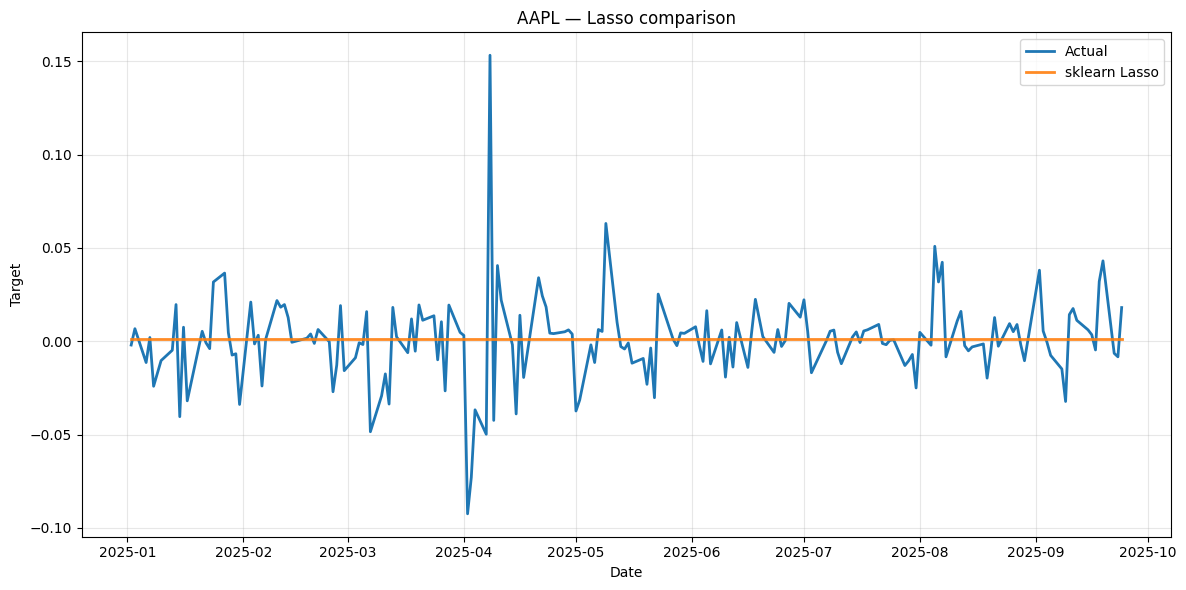


--- sklearn Lasso (coordinate descent) for META ---
Best params (sklearn): {'sklasso__alpha': 0.01, 'sklasso__max_iter': 10000} 
 MAE: 0.01679719393209112 
 RMSE: 0.0250 
 R2: -0.0003 
 Error %: 1087.1316758062374
sklearn Lasso top coefficients:
 Volume         0.0
Return         0.0
RSI            0.0
MACD           0.0
Signal_Line    0.0
STD20          0.0


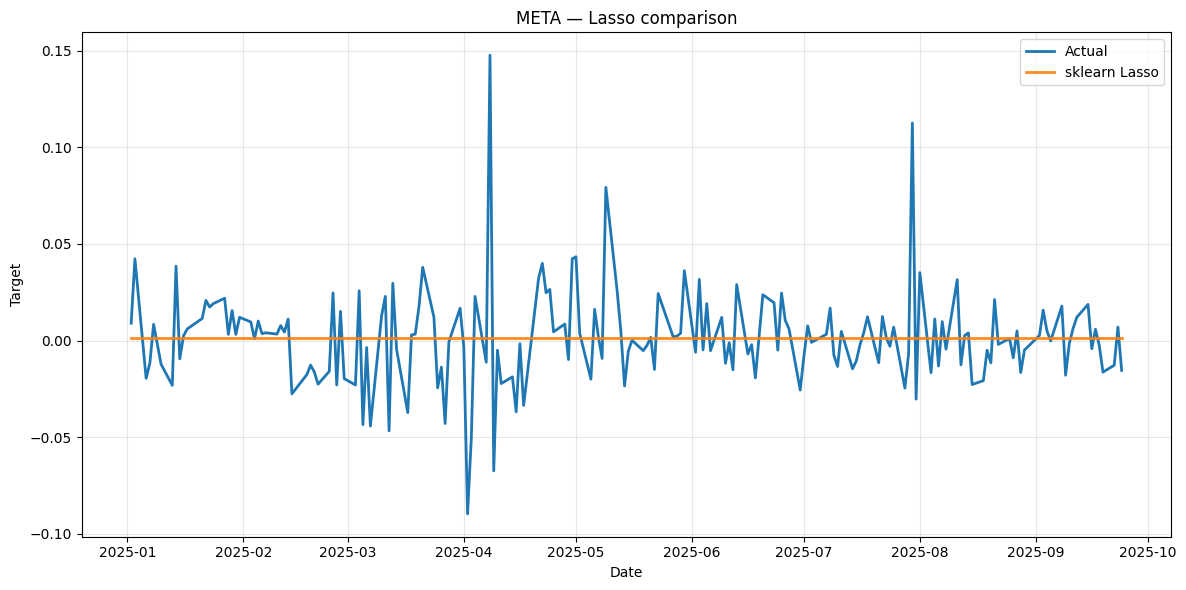


--- sklearn Lasso (coordinate descent) for ORCL ---
Best params (sklearn): {'sklasso__alpha': 0.01, 'sklasso__max_iter': 10000} 
 MAE: 0.02424030590677136 
 RMSE: 0.0412 
 R2: -0.0060 
 Error %: 618.7099498061217
sklearn Lasso top coefficients:
 Volume         0.0
Return         0.0
RSI            0.0
MACD           0.0
Signal_Line    0.0
STD20          0.0


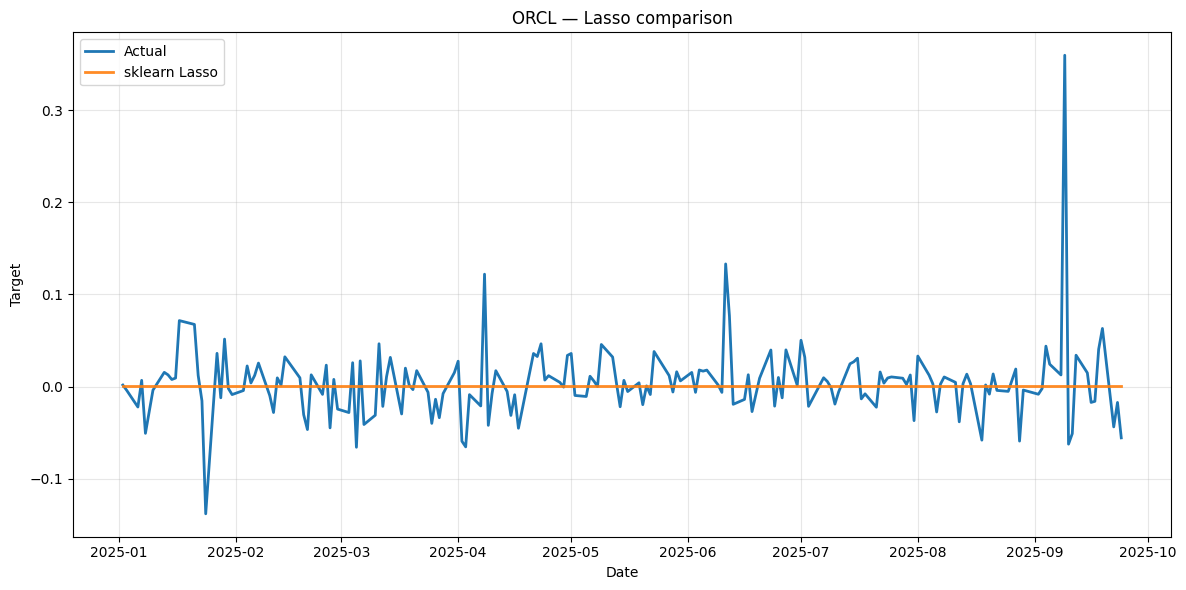


--- sklearn Lasso (coordinate descent) for MSFT ---
Best params (sklearn): {'sklasso__alpha': 0.01, 'sklasso__max_iter': 10000} 
 MAE: 0.010510909127031107 
 RMSE: 0.0164 
 R2: -0.0001 
 Error %: 864.1627926653345
sklearn Lasso top coefficients:
 Volume         0.0
Return         0.0
RSI            0.0
MACD           0.0
Signal_Line    0.0
STD20          0.0


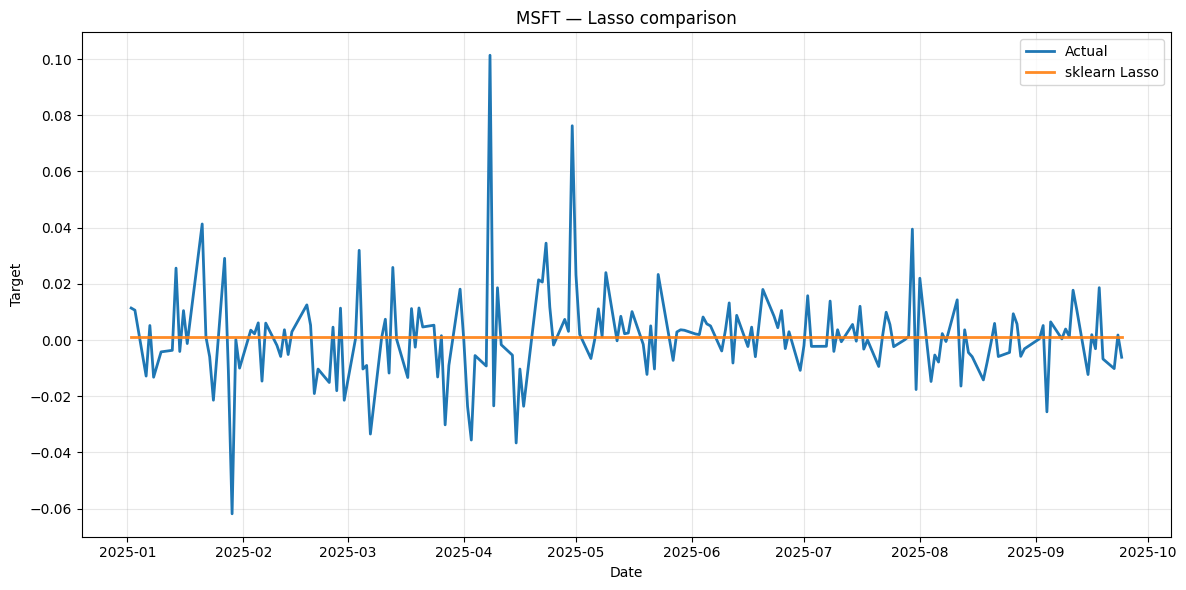

In [35]:
# Sklearn std lasso
for stock, data in data_set.items():

    print(f"\n--- sklearn Lasso (coordinate descent) for {stock} ---")
    pipe_skl = Pipeline([("scaler", StandardScaler()), ("sklasso", Lasso(random_state=42, max_iter=10000))])
    param_skl = {
        'sklasso__alpha': [0.01, 0.1, 1.0, 5.0],
        'sklasso__max_iter': [10000, 50000]
    }
    gs_skl = GridSearchCV(pipe_skl, param_skl, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs_skl.fit(data["X_train"], data["Y_train"])
    best_skl = gs_skl.best_estimator_
    y_pred_skl = best_skl.predict(data["X_test"])
    mse_skl = mean_squared_error(data["Y_test"], y_pred_skl)
    mae_skl = mean_absolute_error(data["Y_test"], y_pred_skl)
    print(f"Best params (sklearn): {gs_skl.best_params_} \n MAE: {mae_skl} \n RMSE: {np.sqrt(mse_skl):.4f} \n R2: {r2_score(data["Y_test"], y_pred_skl):.4f} \n Error %: {(mae_skl/data["Y_test"].mean())*100}")

    # show top coefficients for sklearn Lasso
    try:
        skl_coef = pd.Series(best_skl.named_steps['sklasso'].coef_, index=data["X_train"].columns)
        print("sklearn Lasso top coefficients:\n", skl_coef.abs().sort_values(ascending=False).head(10).to_string())
    except Exception:
        pass

    # plot comparison
    plt.figure(figsize=(12,6))
    plt.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    plt.plot(data["Y_test"].index, y_pred_skl, label='sklearn Lasso', color='#ff7f0e', linewidth=2, alpha=0.9)
    plt.title(f"{stock} — Lasso comparison")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


--- celer Lasso (fast solvers) for AAPL ---
Best params (celer): {'celer__alpha': 0.01, 'celer__max_iter': 10000} 
 MAE: 3.1395761583639477 
 RMSE: 4.7381 
 R2: 0.9201 
 Error %: 1.435577251732458
celer Lasso top coefficients:
 Close          65.434234
STD20           0.035134
Signal_Line     0.031065
RSI             0.023017
Return          0.018928
EMA20           0.015678
High            0.011309
WMA20           0.010930
Volume          0.010180
Low             0.006937


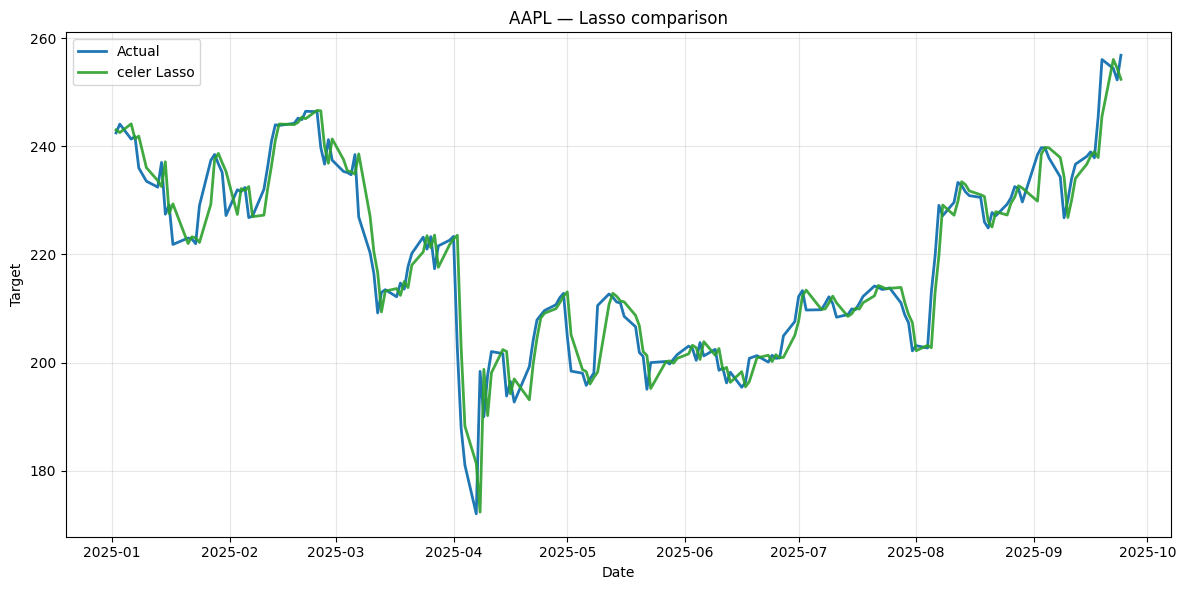


--- celer Lasso (fast solvers) for META ---
Best params (celer): {'celer__alpha': 0.01, 'celer__max_iter': 10000} 
 MAE: 10.822228198694447 
 RMSE: 15.3812 
 R2: 0.9580 
 Error %: 1.6187923376785425
celer Lasso top coefficients:
 Close          119.287193
High             1.286013
Signal_Line      0.512494
MACD             0.461608
Volume           0.193166
Open             0.179973
Low              0.123306
WMA20            0.116367
EMA20            0.102150
STD20            0.094157


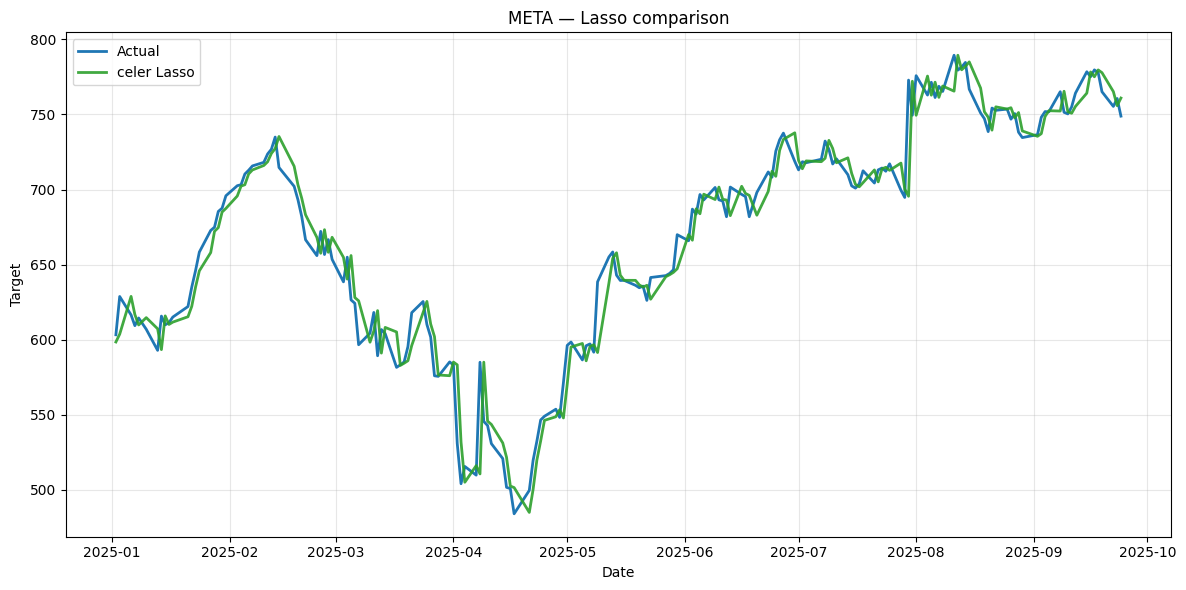


--- celer Lasso (fast solvers) for ORCL ---
Best params (celer): {'celer__alpha': 0.01, 'celer__max_iter': 10000} 
 MAE: 4.7460840097387855 
 RMSE: 8.8687 
 R2: 0.9679 
 Error %: 2.4693181767480223
celer Lasso top coefficients:
 Close          32.246324
High            0.746803
Open            0.649134
Low             0.137436
Signal_Line     0.067949
RSI             0.021898
Volume          0.000000
Return          0.000000
WMA20           0.000000
EMA20           0.000000


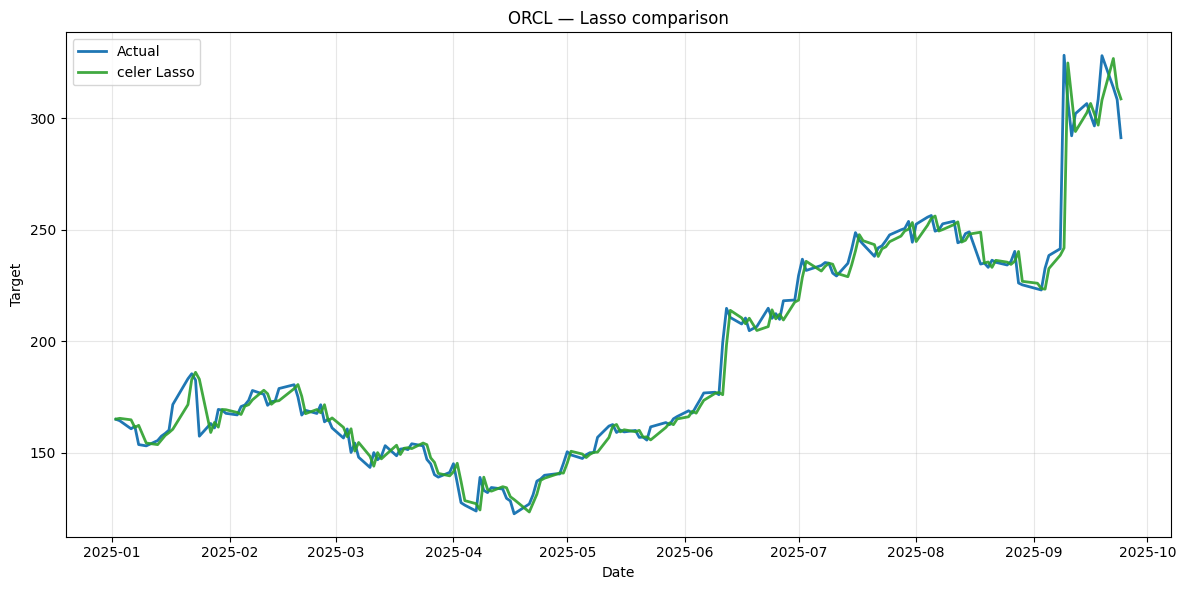


--- celer Lasso (fast solvers) for MSFT ---
Best params (celer): {'celer__alpha': 0.1, 'celer__max_iter': 10000} 
 MAE: 4.543026774511933 
 RMSE: 6.7758 
 R2: 0.9830 
 Error %: 1.009975453250961
celer Lasso top coefficients:
 Close     122.149019
High        0.603870
EMA20       0.163953
Open        0.108504
Low         0.043319
Volume      0.000000
Return      0.000000
WMA20       0.000000
RSI         0.000000
MACD        0.000000


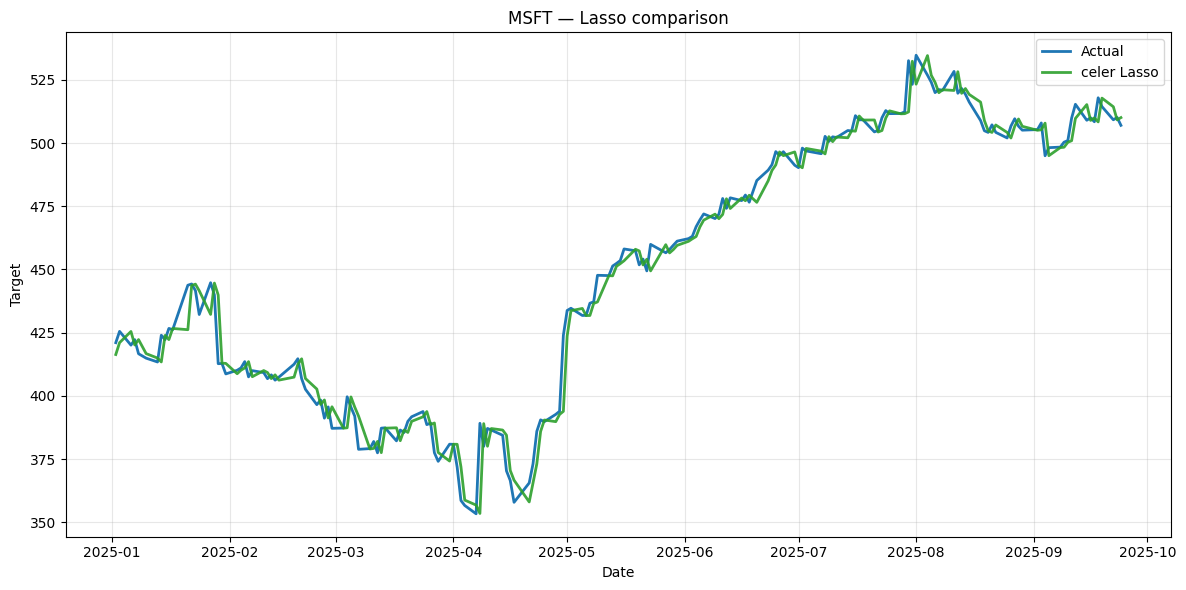

In [33]:
# Lasso celer 
for stock, data in data_set.items():
    print(f"\n--- celer Lasso (fast solvers) for {stock} ---")
    pipe_celer = Pipeline([("scaler", StandardScaler()), ("celer", CelerLasso(max_iter=10000))])
    param_celer = {
        'celer__alpha': [0.01, 0.1, 1.0, 5.0],
        'celer__max_iter': [10000, 50000]
    }
    gs_celer = GridSearchCV(pipe_celer, param_celer, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs_celer.fit(data["X_train"], data["Y_train"])
    best_celer = gs_celer.best_estimator_
    y_pred_celer = best_celer.predict(data["X_test"])
    mse_c = mean_squared_error(data["Y_test"], y_pred_celer)
    mae_c = mean_absolute_error(data["Y_test"], y_pred_celer)
    print(f"Best params (celer): {gs_celer.best_params_} \n MAE: {mae_c} \n RMSE: {np.sqrt(mse_c):.4f} \n R2: {r2_score(data["Y_test"], y_pred_celer):.4f} \n Error %: {(mae_c/data["Y_test"].mean())*100}")

    try:
        cel_coef = pd.Series(best_celer.named_steps['celer'].coef_, index=data["X_train"].columns)
        print("celer Lasso top coefficients:\n", cel_coef.abs().sort_values(ascending=False).head(10).to_string())
    except Exception:
        pass

    # plot comparison
    plt.figure(figsize=(12,6))
    plt.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    plt.plot(data["Y_test"].index, y_pred_celer, label='celer Lasso', color='#2ca02c', linewidth=2, alpha=0.9)  
    plt.title(f"{stock} — Lasso comparison")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()